<a href="https://colab.research.google.com/github/JHyunjun/TF2.0_Generative-Adversarial-Network/blob/main/GAN_JSAE_delta_250307.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

   Current    SOC  Voltage   △I   △V
0    -13.7  100.0    746.3  0.0  0.0
1    -14.0  100.0    746.4 -0.3  0.1
2    -13.8  100.0    746.2  0.2 -0.2
3    -14.1  100.0    746.3 -0.3  0.1
4    -13.9  100.0    746.1  0.2 -0.2


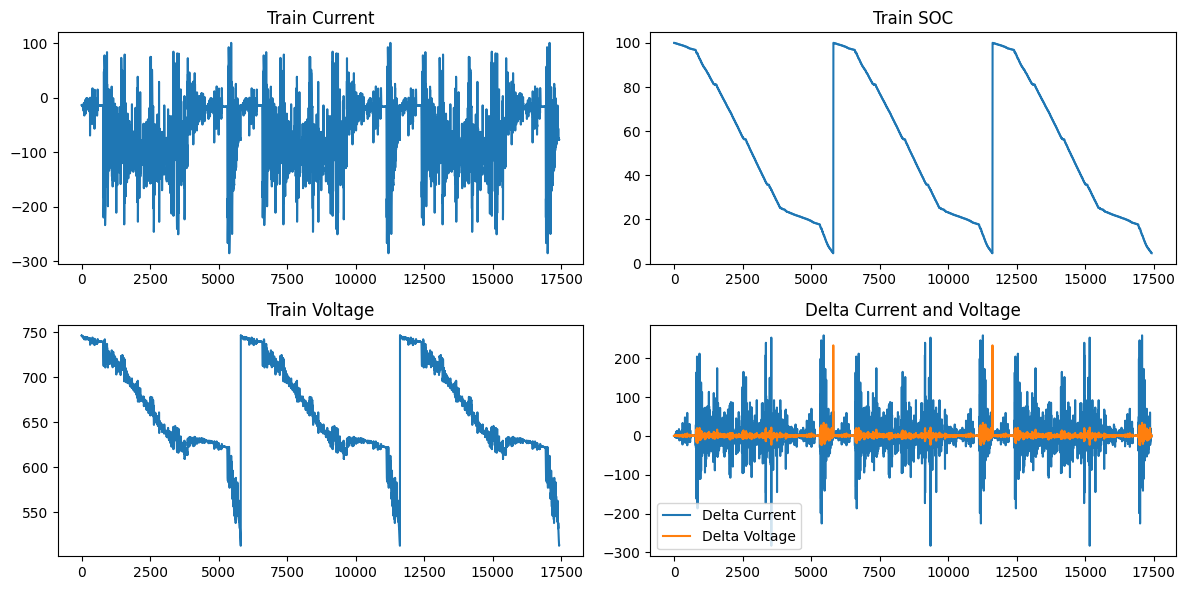

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Flatten, Dense, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay

tf.keras.mixed_precision.set_global_policy('mixed_float16')


import numpy as np
import matplotlib.pyplot as plt

def MinMaxScaler(data, data_min, data_max): # Scaling to 0~1
    return (data - data_min) / (data_max - data_min + 1e-7)

def min_max_scaler_neg1_to_1(data, data_min, data_max): # Scailing to -1~1 for tanh
    # data_min, data_max는 각각 각 피처의 최소, 최대값 (numpy array)
    return 2 * (data - data_min) / (data_max - data_min + 1e-7) - 1

def denormalize_feature(data, feature_index, data_min, data_max):
    # data: numpy array with shape (..., features)
    # 개별 피처(feature_index)에 대해 de-normalize 수행
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

train_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt", delimiter=",")
test_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt", delimiter=",")

# 데이터 반복 (예: train_data를 3배 반복)
train_data = pd.concat([train_data, train_data, train_data], ignore_index=True)

# 필요한 열만 선택 (예: 0,2,4번 열)
train_data = train_data.iloc[:, [0, 2, 4]]
cols = ['Current', 'SOC', 'Voltage']
train_data.columns = cols

test_data = test_data.iloc[:, [0, 2, 4]]
test_data.columns = cols

# △I, △V 열 추가: 각 행의 현재 값과 바로 이전 행의 차이 (첫 행은 0으로 채움)
train_data['△I'] = train_data['Current'].diff().fillna(0)
train_data['△V'] = train_data['Voltage'].diff().fillna(0)

# 추가된 열 확인
print(train_data.head())

# 플롯 예시 (기존 플롯에 추가 열도 그려볼 수 있음)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(train_data['Current'])
plt.title("Train Current")

plt.subplot(2, 2, 2)
plt.plot(train_data['SOC'])
plt.title("Train SOC")

plt.subplot(2, 2, 3)
plt.plot(train_data['Voltage'])
plt.title("Train Voltage")

plt.subplot(2, 2, 4)
plt.plot(train_data['△I'], label="Delta Current")
plt.plot(train_data['△V'], label="Delta Voltage")
plt.title("Delta Current and Voltage")
plt.legend()
plt.tight_layout()
plt.show()

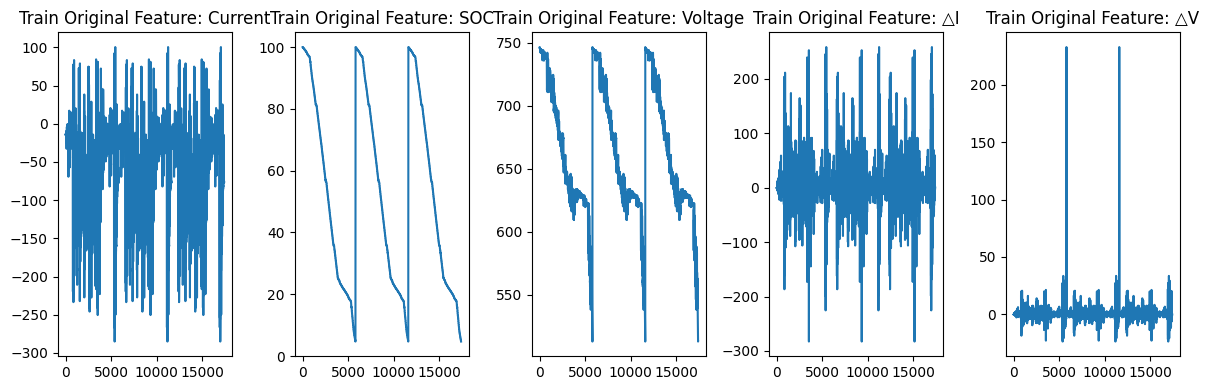

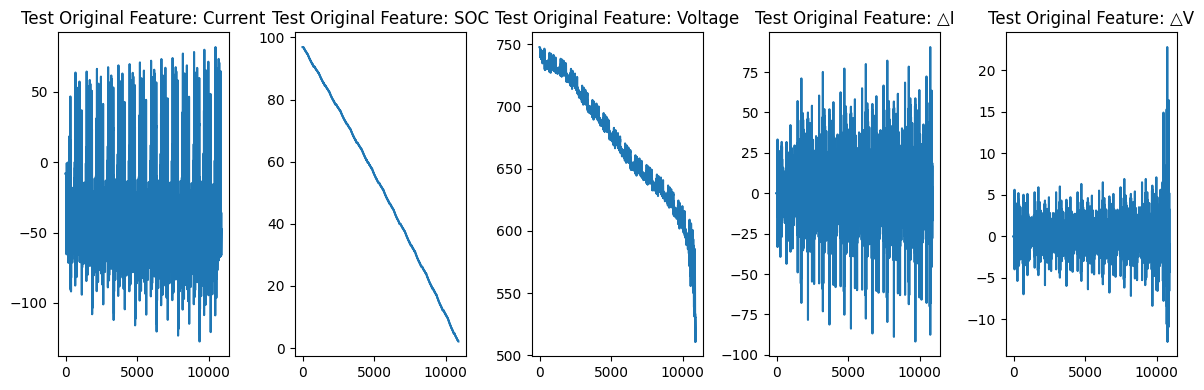

Scaled Train data :
 [[0.70383817 1.         0.99450549 0.52226122 0.09236165]
 [0.70306017 1.         0.99492815 0.521707   0.09275136]
 [0.70357884 1.         0.99408284 0.5226307  0.09158223]
 ...
 [0.54149378 0.02655771 0.01183432 0.52189174 0.09002338]
 [0.54175311 0.02655771 0.00887574 0.52244596 0.08963367]
 [0.5409751  0.02655771 0.0101437  0.521707   0.09353079]]
Scaled Test data :
 [[0.71810166 0.96833503 1.         0.52226122 0.09236165]
 [0.71810166 0.96833503 1.         0.52226122 0.09236165]
 [0.71810166 0.96833503 1.         0.52226122 0.09236165]
 ...
 [0.57131743 0.         0.01690617 0.521707   0.08222915]
 [0.57053942 0.         0.00803043 0.521707   0.08417771]
 [0.57002075 0.         0.         0.52189174 0.08495713]]
Scaled Combined data:
 (28303, 5) [[-1.370e+01  1.000e+02  7.463e+02  0.000e+00  0.000e+00]
 [-1.400e+01  1.000e+02  7.464e+02 -3.000e-01  1.000e-01]
 [-1.380e+01  1.000e+02  7.462e+02  2.000e-01 -2.000e-01]
 ...
 [-6.480e+01  2.100e+00  5.150e+02 -3.

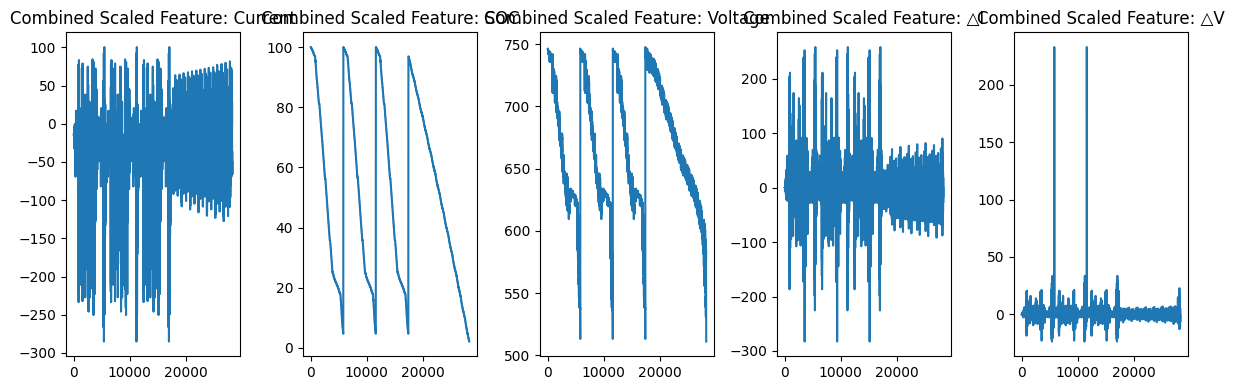

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Mixed precision 설정
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Scaling 함수들
def MinMaxScaler(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min + 1e-7)

def min_max_scaler_neg1_to_1(data, data_min, data_max):
    return 2 * (data - data_min) / (data_max - data_min + 1e-7) - 1

def denormalize_feature(data, feature_index, data_min, data_max):
    return data[..., feature_index] * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

def denorm_vector(vec, feature_index, data_min, data_max):
    return vec * (data_max[feature_index] - data_min[feature_index]) + data_min[feature_index]

# 데이터 로드
train_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt", delimiter=",")
test_data = pd.read_csv(r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt", delimiter=",")

# train_data를 3배 반복 (원하는 경우)
train_data = pd.concat([train_data, train_data, train_data], ignore_index=True)

# 필요한 열만 선택: 여기서는 0번(Current), 2번(SOC), 4번(Pack Voltage)을 사용
train_data = train_data.iloc[:, [0, 2, 4]]
test_data = test_data.iloc[:, [0, 2, 4]]
# 열 이름 지정
cols = ['Current', 'SOC', 'Voltage']
train_data.columns = cols
test_data.columns = cols

# △I, △V 열 추가 (각 행에서 이전 행과의 차이; 첫 행은 0으로 채움)
train_data['△I'] = train_data['Current'].diff().fillna(0)
train_data['△V'] = train_data['Voltage'].diff().fillna(0)
test_data['△I'] = test_data['Current'].diff().fillna(0)
test_data['△V'] = test_data['Voltage'].diff().fillna(0)

# 새 열 이름: 이제 총 5개 열
cols = ['Current', 'SOC', 'Voltage', '△I', '△V']

# 데이터 시각화: 각 피처 확인
plt.figure(figsize=(12, 4))
for i in range(train_data.shape[1]):
    plt.subplot(1, train_data.shape[1], i+1)
    plt.plot(train_data.iloc[:, i])
    plt.title(f"Train Original Feature: {cols[i]}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
for i in range(test_data.shape[1]):
    plt.subplot(1, test_data.shape[1], i+1)
    plt.plot(test_data.iloc[:, i])
    plt.title(f"Test Original Feature: {cols[i]}")
plt.tight_layout()
plt.show()

# Data Normalization (0~1)
combined_data = pd.concat([train_data, test_data], ignore_index=True)
data_min = combined_data.min().values
data_max = combined_data.max().values
train_scaled = MinMaxScaler(train_data.values, data_min, data_max)
test_scaled = MinMaxScaler(test_data.values, data_min, data_max)
print("Scaled Train data :\n", train_scaled)
print("Scaled Test data :\n", test_scaled)
print("Scaled Combined data:\n", combined_data.shape, combined_data.values)

# Data Slicing (여기서는 overlap=0.8 사용, 즉 stride = int(window_size * (1-0.8)) = int(20*0.2)=4)
window_size = 20
overlap_factor = 0.7

def create_sequences_non_overlapping(data, window_size=window_size, overlap=overlap_factor):
    stride = int(window_size * (1 - overlap))
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

train_sequences = create_sequences_non_overlapping(train_scaled, window_size=window_size, overlap=overlap_factor)
all_sequences = create_sequences_non_overlapping(np.concatenate([train_scaled, test_scaled], axis=0), window_size=window_size, overlap=overlap_factor)

print("Train data.shape : ", train_scaled.shape)
print("Train sequences shape : ", train_sequences.shape)
print("All data.shape : ", combined_data.shape)
print("All sequences shape : ", all_sequences.shape)

# Combined 데이터 시각화
plt.figure(figsize=(12, 4))
for i in range(combined_data.shape[1]):
    plt.subplot(1, combined_data.shape[1], i+1)
    plt.plot(combined_data.iloc[:, i])
    plt.title(f"Combined Scaled Feature: {cols[i]}")
plt.tight_layout()
plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, LSTM, TimeDistributed, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam

# # Mixed precision (옵션)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ############################################
# # 1. 데이터 로드 및 전처리
# ############################################

# def MinMaxScaler(data, data_min, data_max):
#     return (data - data_min) / (data_max - data_min + 1e-7)

# # CSV 파일 경로 (경로는 환경에 맞게 수정)
# train_path = r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\train_v.txt"
# test_path  = r"C:\Users\user\Desktop\SNU\논문코드\JSAEGAN\test_v.txt"

# # 데이터 로드
# train_data = pd.read_csv(train_path, delimiter=",")
# test_data  = pd.read_csv(test_path, delimiter=",")

# # Train 데이터를 3배 반복 (데이터양 증가)
# train_data = pd.concat([train_data, train_data, train_data], ignore_index=True)

# # 필요한 열 선택: 여기서는 0번(Current), 2번(SOC), 4번(Voltage)
# train_data = train_data.iloc[:, [0, 2, 4]]
# test_data  = test_data.iloc[:, [0, 2, 4]]
# cols = ['Current', 'SOC', 'Voltage']
# train_data.columns = cols
# test_data.columns = cols

# # △I, △V 열 추가 (현재 값과 바로 이전 행의 차이; 첫 행은 0으로 채움)
# train_data['△I'] = train_data['Current'].diff().fillna(0)
# train_data['△V'] = train_data['Voltage'].diff().fillna(0)
# test_data['△I'] = test_data['Current'].diff().fillna(0)
# test_data['△V'] = test_data['Voltage'].diff().fillna(0)

# # 총 5개 열: [Current, SOC, Voltage, △I, △V]
# print("Train data head:")
# print(train_data.head())

# # (옵션) 데이터 시각화
# plt.figure(figsize=(12, 6))
# plt.subplot(2,2,1)
# plt.plot(train_data['Current'])
# plt.title("Train Current")
# plt.subplot(2,2,2)
# plt.plot(train_data['SOC'])
# plt.title("Train SOC")
# plt.subplot(2,2,3)
# plt.plot(train_data['Voltage'])
# plt.title("Train Voltage")
# plt.subplot(2,2,4)
# plt.plot(train_data['△I'], label="ΔI")
# plt.plot(train_data['△V'], label="ΔV")
# plt.title("Train ΔI & ΔV")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Data Normalization (0 ~ 1)
# combined_data = pd.concat([train_data, test_data], ignore_index=True)
# data_min = combined_data.min().values
# data_max = combined_data.max().values
# train_scaled = MinMaxScaler(train_data.values, data_min, data_max)
# test_scaled  = MinMaxScaler(test_data.values, data_min, data_max)
# print("Scaled Train data shape:", train_scaled.shape)

# ############################################
# # 2. 슬라이딩 윈도우 시퀀스 생성
# ############################################

# def create_sequences_non_overlapping(data, window_size, overlap):
#     stride = int(window_size * (1 - overlap))
#     sequences = []
#     for i in range(0, len(data) - window_size + 1, stride):
#         sequences.append(data[i:i+window_size])
#     return np.array(sequences)

# # 전체 데이터를 합친 후 슬라이딩 윈도우 생성
# all_data = np.concatenate([train_scaled, test_scaled], axis=0)
# all_sequences = create_sequences_non_overlapping(all_data, window_size, overlap_factor)
# print("All sequences shape:", all_sequences.shape)
# # all_sequences의 shape: (num_sequences, window_size, 5)

# ############################################
# # 3. Teacher 모델 학습 데이터 구성
# ############################################

# # Teacher 모델의 입력: [Current, SOC, ΔI, ΔV] → 인덱스 [0,1,3,4]
# # Teacher 모델의 출력: [Voltage] → 인덱스 [2]
# teacher_X = all_sequences[..., [0, 1, 3, 4]]  # shape: (N, window_size, 4)
# teacher_Y = all_sequences[..., 2:3]           # shape: (N, window_size, 1)

# print("Teacher X shape:", teacher_X.shape)
# print("Teacher Y shape:", teacher_Y.shape)

# ############################################
# # 4. Teacher 모델 정의 & 학습 (1D CNN 모델)
# ############################################

# def build_teacher_1d_cnn(input_shape):
#     inp = Input(shape=input_shape)  # (window_size, 4)
#     x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inp)
#     x = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(x)
#     x = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(x)
#     x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
#     # 마지막 출력층에 Sigmoid 활성화를 사용하여 출력값을 [0,1] 범위로 제한 (Voltage는 정규화된 값)
#     out = Conv1D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(x)
#     model = Model(inp, out, name="Teacher_1D_CNN")
#     return model

# teacher_1d = build_teacher_1d_cnn((window_size, 4))
# teacher_1d.summary()
# teacher_1d.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# # 전체 데이터를 사용하여 학습 (validation_split 없이)
# history_1d = teacher_1d.fit(teacher_X, teacher_Y,
#                              epochs=300,
#                              batch_size=64,
#                              verbose=1)

# teacher_1d.save("refined_1d_cnn_deltaiv.h5")
# print("1D-CNN Teacher model saved as refined_1d_cnn_deltaiv.h5")

# ############################################
# # 5. Teacher 모델 정의 & 학습 (LSTM 모델)
# ############################################

# def build_teacher_lstm(input_shape):
#     inp = Input(shape=input_shape)  # (window_size, 4)
#     x = tf.cast(inp, tf.float32)
#     x = LSTM(128, return_sequences=True, activation = 'relu')(inp)
#     x = LSTM(128, return_sequences=True, activation = 'relu')(x)
#     x = LSTM(64, return_sequences=True, activation = 'relu')(x)
#     x = LSTM(64, return_sequences=True, activation = 'relu')(x)
#     # TimeDistributed Dense에 Sigmoid 활성화를 적용하여 출력값을 [0,1]로 제한
#     out = TimeDistributed(Dense(1, activation='sigmoid'))(x)
#     model = Model(inp, out, name="Teacher_LSTM")
#     return model

# teacher_lstm = build_teacher_lstm((window_size, 4))
# teacher_lstm.summary()
# teacher_lstm.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

# history_lstm = teacher_lstm.fit(teacher_X, teacher_Y,
#                                 epochs=100,
#                                 batch_size=64,
#                                 verbose=1)

# teacher_lstm.save("refined_lstm_deltaiv.h5")
# print("LSTM Teacher model saved as refined_lstm_deltaiv.h5")

# ############################################
# # 6. 전체 학습 데이터에 대한 평가 및 플로팅 (Denormalized)
# ############################################

# # 6.1 전체 데이터를 대상으로 모델 평가 (loss 계산)
# train_loss = teacher_1d.evaluate(teacher_X, teacher_Y, verbose=0)
# print("전체 학습 데이터에 대한 평가 loss (1D-CNN):", train_loss)

# # 6.2 전체 데이터를 대상으로 예측 수행 (normalized 값)
# train_predictions = teacher_1d.predict(teacher_X)  # shape: (N, window_size, 1)

# # 6.3 실제 teacher_Y와 예측 결과를 1차원 배열로 평탄화
# all_true = teacher_Y.reshape(-1)         # shape: (N * window_size,)
# all_pred = train_predictions.reshape(-1)   # shape: (N * window_size,)
# all_error = all_true - all_pred            # 오차 (normalized)

# # 6.4 Denormalize: Voltage는 원래 데이터에서 인덱스 2에 해당
# def denorm_vector(vec, feature_index, data_min, data_max):
#     return vec * (data_max[feature_index] - data_min[feature_index] + 1e-7) + data_min[feature_index]

# all_true_denorm = denorm_vector(all_true, 2, data_min, data_max)
# all_pred_denorm = denorm_vector(all_pred, 2, data_min, data_max)
# all_error_denorm = all_true_denorm - all_pred_denorm

# # 6.5 플롯 1: 실제 전압 vs 예측 전압 (denormalized)
# plt.figure(figsize=(14, 5))
# plt.plot(all_true_denorm, label='True Voltage', marker='o', markersize=2, linewidth=1)
# plt.plot(all_pred_denorm, label='Predicted Voltage', marker='x', markersize=2, linewidth=1)
# plt.title("전체 학습 데이터에 대한 전압 예측 비교 (Denormalized)")
# plt.xlabel("샘플 인덱스 (Flattened)")
# plt.ylabel("Voltage")
# plt.legend()
# plt.tight_layout()
# plt.show()

# # 6.6 플롯 2: 예측 오차 (denormalized)
# plt.figure(figsize=(14, 5))
# plt.plot(all_error_denorm, label='Error (True - Predicted)', marker='s', markersize=2, linewidth=1, color='red')
# plt.title("전체 학습 데이터에 대한 예측 오차 (Denormalized)")
# plt.xlabel("샘플 인덱스 (Flattened)")
# plt.ylabel("Voltage Error")
# plt.legend()
# plt.tight_layout()
# plt.show()


In [ ]:
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, ConvLSTM2D, TimeDistributed, Conv2D, Flatten, Input, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Hyper Parameters
feature_dim = 5        # 원본 all_sequences는 5채널: [전류, SOC, 전압, ΔI, ΔV]
latent_dim = 50        # 노이즈 차원
batch_size = 256
epochs = 1200
n_critic = 3
lambda_gp = 10.0
learning_rate = 5e-4

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# --- Gradient Penalty 계산 함수 (WGAN-GP) ---
@tf.function
def gradient_penalty(discriminator, real_samples, fake_samples):
    fake_samples = tf.cast(fake_samples, real_samples.dtype)
    batch_size = tf.shape(real_samples)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0.0, 1.0, dtype=real_samples.dtype)
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    grads = gp_tape.gradient(pred, [interpolated])[0]
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    gp = tf.reduce_mean((grad_norm - 1.0) ** 2)
    return gp

# Teacher 모델들은 입력 shape (window_size, 3)를 기대합니다.
# Teacher 모델은 [전류, ΔI, ΔV]를 입력으로 받아 전압을 예측하도록 학습되었습니다.
teacher_model = tf.keras.models.load_model("refined_1d_cnn_deltaiv.h5")
teacher_model_2 = tf.keras.models.load_model("refined_lstm_deltaiv.h5")
teacher_model.trainable = False
teacher_model_2.trainable = False

# --- Generator ---
# get_condition: 조건으로 SOC를 추출 (여전히 사용하지만 최종 출력에는 반영하지 않습니다)
def get_condition(real_series):
    # real_series: (batch, window_size, feature_dim)
    # 조건: SOC는 두번째 피처
    soc = real_series[:, -1, 1]       # (batch,)
    soc = tf.expand_dims(soc, axis=1)   # (batch, 1)
    soc = tf.tile(soc, [1, window_size])# (batch, window_size)
    soc = tf.expand_dims(soc, axis=-1)  # (batch, window_size, 1)
    return soc

# Generator는 노이즈와 조건(SOC)을 받아 동적 피처로 [전류, ΔI, ΔV] (3채널)를 생성하도록 구성하고,
# 최종 combine_output은 조건을 무시하고 Generator 출력 그대로 반환하여 최종 생성 시퀀스가 [전류, SOC, ΔI, ΔV]가 아니라
# [전류, ΔI, ΔV, 전압]을 생성하도록 합니다.
# 여기서 우리가 원하는 최종 ordering는: [전류, ΔI, ΔV, 전압]
def build_generator_cond(latent_dim, window_size):
    noise_inp = Input(shape=(window_size, latent_dim))
    cond_inp = Input(shape=(window_size, 1))
    x = Concatenate(axis=-1)([noise_inp, cond_inp])
    x = TimeDistributed(Dense(64))(x)
    x = TimeDistributed(LeakyReLU(alpha=0.2))(x)
    x = Reshape((window_size, 1, 64, 1))(x)
    x = ConvLSTM2D(filters=64, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=64, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=64, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = ConvLSTM2D(filters=64, kernel_size=(1,3), padding='same', return_sequences=True)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = TimeDistributed(Conv2D(filters=1, kernel_size=(1,3), padding='same'))(x)
    x = TimeDistributed(LeakyReLU(alpha=0.2))(x)
    x = TimeDistributed(Flatten())(x)
    # 최종 출력: Dense(4, activation='sigmoid') → 4채널: [전류, ΔI, ΔV, 전압]
    dynamic_out = TimeDistributed(Dense(4, activation='sigmoid'))(x)
    model = Model([noise_inp, cond_inp], dynamic_out, name="Generator_Conditional")
    return model

# combine_output: Generator의 동적 출력 이미 4채널이므로 그대로 반환
def combine_output(dynamic, cond):
    return dynamic

generator_cond = build_generator_cond(latent_dim, window_size)

# --- Discriminator ---
# 최종 생성 시퀀스: [전류, ΔI, ΔV, 전압] → 4채널
def build_discriminator(input_shape):
    model = Sequential(name="Critic")
    # 입력 shape: (window_size, 4)
    window_size = input_shape[0]
    num_features = input_shape[1]
    model.add(Reshape((window_size, 1, num_features, 1), input_shape=input_shape))
    model.add(ConvLSTM2D(filters=32, kernel_size=(1, num_features), padding='same', return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(ConvLSTM2D(filters=16, kernel_size=(1, num_features), padding='same', return_sequences=True))
    model.add(LeakyReLU(alpha=0.2))
    model.add(ConvLSTM2D(filters=8, kernel_size=(1, num_features), padding='same', return_sequences=False))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1))
    return model

discriminator = build_discriminator((window_size, 4))

# --- Optimizers and Dataset ---
generator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.9)
dataset = tf.data.Dataset.from_tensor_slices(all_sequences.astype('float32')).shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# -----------------------------
# Training Step
# -----------------------------
@tf.function
def train_step(real_series):
    # real_series: (batch, window_size, feature_dim) → feature_dim=5, 순서: [전류, SOC, 전압, ΔI, ΔV]
    # 1. Discriminator 업데이트
    cond = get_condition(real_series)  # (batch, window_size, 1)
    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim])
    latent_fake = generator_cond([noise, cond], training=True)  # (batch, window_size, 4)
    fake_series = combine_output(latent_fake, cond)  # (batch, window_size, 4), ordering: [전류, ΔI, ΔV, 전압]

    # real_series의 Discriminator 입력: 사용하려는 채널: [전류, ΔI, ΔV, 전압] → 열 인덱스 [0,3,4,2]
    real_for_disc = tf.stack([real_series[..., 0], real_series[..., 3], real_series[..., 4], real_series[..., 2]], axis=-1)

    with tf.GradientTape() as tape:
        d_real = discriminator(real_for_disc, training=True)
        d_fake = discriminator(fake_series, training=True)
        d_loss = tf.reduce_mean(d_fake) - tf.reduce_mean(d_real)
        gp = gradient_penalty(discriminator, real_for_disc, fake_series)
        d_loss_total = d_loss + tf.cast(lambda_gp, d_loss.dtype) * tf.cast(gp, d_loss.dtype)
    gradients = tape.gradient(d_loss_total, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))

    # 2. Generator 업데이트
    noise = tf.random.normal([tf.shape(real_series)[0], window_size, latent_dim])
    with tf.GradientTape() as tape:
        latent_fake = generator_cond([noise, cond], training=True)
        fake_series = combine_output(latent_fake, cond)  # (batch, window_size, 4)
        d_fake = discriminator(fake_series, training=True)
        g_adv_loss = -tf.reduce_mean(d_fake)

        # Teacher 모델을 이용한 supervised loss 계산
        # Teacher 모델은 [전류, ΔI, ΔV] (채널 0~2)를 입력으로 받아 전압을 예측함.
        teacher_input = tf.concat([
            fake_series[..., :1],               # 전류 (채널 0)
            tf.cast(cond, fake_series.dtype),    # SOC (조건, 채널 1)
            fake_series[..., 1:3]                # 델타 i, 델타 v (채널 1~2)
        ], axis=-1)  # 최종 teacher_input shape: (batch, window_size, 4)

        teacher_prediction = teacher_model(teacher_input, training=False)  # (batch, window_size, 1)
        teacher_prediction_2 = teacher_model_2(teacher_input, training=False)
        # 실제 생성된 전압: fake_series의 채널 3 (shape: (batch, window_size, 1))
        teacher_loss = tf.reduce_mean(tf.square(teacher_prediction - tf.cast(fake_series[..., 3:4], teacher_prediction.dtype)))
        teacher_loss_2 = tf.reduce_mean(tf.square(teacher_prediction_2 - tf.cast(fake_series[..., 3:4], teacher_prediction_2.dtype)))

        alpha = 3.0
        beta = 3.0
        g_loss_total = g_adv_loss + tf.cast(alpha * teacher_loss, g_adv_loss.dtype) + tf.cast(beta * teacher_loss_2, g_adv_loss.dtype)
    gradients = tape.gradient(g_loss_total, generator_cond.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator_cond.trainable_variables))

    return d_loss, g_loss_total, gp


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# 예시 하이퍼파라미터
initial_lr = learning_rate
decay_rate = 0.95  # 100 epoch마다 적용할 decay factor

# Optimizer 생성 (초기 lr로 설정)
generator_optimizer = Adam(learning_rate=initial_lr, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=initial_lr, beta_1=0.5, beta_2=0.9)

# Training Loop 내에서 매 100 epoch마다 lr 업데이트
for epoch in range(epochs):
    if epoch % 100 == 0 and epoch != 0:
        # 매 100 epoch마다 새로운 lr 계산:
        # new_lr = initial_lr * (decay_rate ** (epoch // 100))
        new_lr = initial_lr * (decay_rate ** (epoch // 100))
        generator_optimizer.learning_rate.assign(new_lr)
        discriminator_optimizer.learning_rate.assign(new_lr)
    # 학습 루프 수행 (여기서는 기존 train_step 함수와 dataset 사용)
    total_d, total_g, total_gp, count = 0.0, 0.0, 0.0, 0
    for real_batch in dataset:
        d_loss_val, g_loss_val, gp_val = train_step(real_batch)
        total_d += d_loss_val
        total_g += g_loss_val
        total_gp += gp_val
        count += 1
    if epoch % 100 == 0:
        current_lr = generator_optimizer.learning_rate.numpy()
        print(f"Epoch {epoch} | lr: {current_lr:.6f} | D Loss: {total_d/count:.4f}, GP: {total_gp/count:.4f}, G Loss: {total_g/count:.4f}")

generator_cond.save("250306_gan_generator.h5")
print("Generator model saved as 250306_gan_generator.h5")


KeyboardInterrupt: 

In [ ]:
print("data_min : ", data_min)
print("data_max : ", data_max)

data_min :  [-285.1    2.1  511.  -282.7  -23.7]
data_max :  [100.5 100.  747.6 258.6 232.9]


Latnent dynamic.shape : (1, 20, 4)
Generated sequence shape: (1, 20, 5)


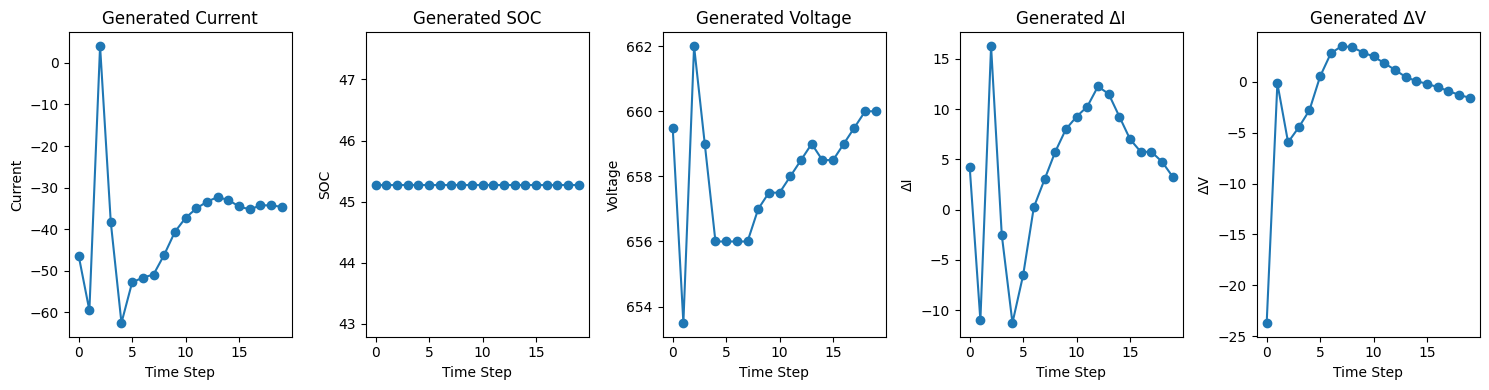

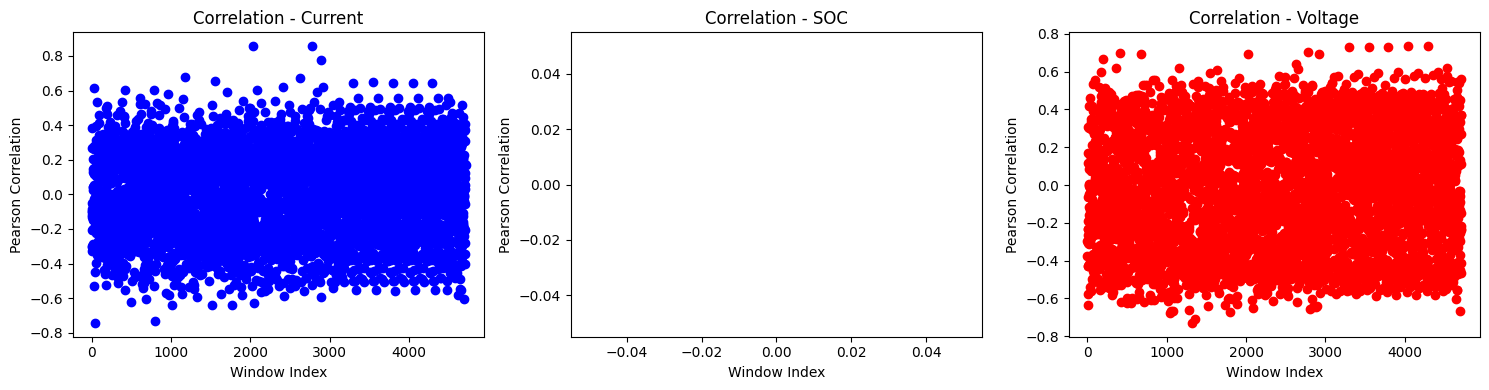

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# -------------------------------------------------------------------
# combine_output 함수 (Generator 출력: [Current, ΔI, ΔV, Voltage])
# 조건(cond_sample, SOC)은 (batch, window_size, 1) 형태이며,
# 최종 ordering: [Current, SOC, Voltage, ΔI, ΔV] (총 5채널)
# -------------------------------------------------------------------
def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 4) → [Current, ΔI, ΔV, Voltage]
    current = dynamic[..., :1]          # (batch, window_size, 1): Current
    remaining = dynamic[..., 1:]          # (batch, window_size, 3): [ΔI, ΔV, Voltage]
    cond = tf.cast(cond, dynamic.dtype)   # (batch, window_size, 1): SOC
    # 최종 생성 시퀀스: [Current, SOC, Voltage, ΔI, ΔV]
    # 주의: 생성된 remaining의 순서를 [ΔI, ΔV, Voltage]에서 [Voltage, ΔI, ΔV]로 재배열
    # 즉, remaining[..., -1:]는 Voltage, remaining[..., :2]는 [ΔI, ΔV]
    voltage = remaining[..., -1:]
    delta = remaining[..., :2]
    return tf.concat([current, cond, voltage, delta], axis=-1)

# -------------------------------------------------------------------
# 생성된 시계열 샘플 확인 (검증용)
# -------------------------------------------------------------------
# 1. 임의의 노이즈 샘플: (1, window_size, latent_dim)
noise_sample = tf.random.normal([1, window_size, latent_dim])
# 2. 조건 샘플: all_sequences의 특정 샘플에서 SOC를 추출 (shape: (1, window_size, 1))
cond_sample = get_condition(all_sequences[500:501])
# 3. 조건부 Generator 실행: Generator는 4채널 출력, ordering: [Current, ΔI, ΔV, Voltage]
latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
print("Latnent dynamic.shape :", latent_dynamic.shape)  # 예상: (1, window_size, 4)
# 4. combine_output: 최종 생성 시퀀스 구성, ordering: [Current, SOC, Voltage, ΔI, ΔV]
generated_sequence = combine_output(latent_dynamic, cond_sample)
print("Generated sequence shape:", generated_sequence.shape)  # 예상: (1, window_size, 5)

# 선택: 첫 번째 시퀀스 추출 (shape: (window_size, 5))
gen_seq = generated_sequence[0].numpy()

# 각 피처별 denormalization (피처 인덱스: 0: Current, 1: SOC, 2: Voltage, 3: ΔI, 4: ΔV)
gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)
gen_deltaV_denorm  = denormalize_feature(gen_seq, 4, data_min, data_max)

# 각 피처별 생성 데이터 시각화 (원래 스케일)
plt.figure(figsize=(15,4))
plt.subplot(1,5,1)
plt.plot(gen_current_denorm, marker='o')
plt.title('Generated Current')
plt.xlabel('Time Step')
plt.ylabel('Current')

plt.subplot(1,5,2)
plt.plot(gen_soc_denorm, marker='o')
plt.title('Generated SOC')
plt.xlabel('Time Step')
plt.ylabel('SOC')

plt.subplot(1,5,3)
plt.plot(gen_voltage_denorm, marker='o')
plt.title('Generated Voltage')
plt.xlabel('Time Step')
plt.ylabel('Voltage')

plt.subplot(1,5,4)
plt.plot(gen_deltaI_denorm, marker='o')
plt.title('Generated ΔI')
plt.xlabel('Time Step')
plt.ylabel('ΔI')

plt.subplot(1,5,5)
plt.plot(gen_deltaV_denorm, marker='o')
plt.title('Generated ΔV')
plt.xlabel('Time Step')
plt.ylabel('ΔV')

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 각 슬라이딩 윈도우별 상관계수 계산
# 전체 슬라이딩 윈도우 (all_sequences) 는 원본 5채널, 순서: [Current, SOC, Voltage, ΔI, ΔV]
# 여기서는 [Current, SOC, Voltage]에 대해 상관계수를 계산합니다.
# -------------------------------------------------------------------
n_windows = all_sequences.shape[0]
corr_current = []
corr_soc = []
corr_voltage = []

for i in range(n_windows):
    window = all_sequences[i]  # shape: (window_size, 5)
    # 각 윈도우에서 원본 피처 추출 및 denormalize
    window_current = denormalize_feature(window, 0, data_min, data_max)
    window_soc     = denormalize_feature(window, 1, data_min, data_max)
    window_voltage = denormalize_feature(window, 2, data_min, data_max)

    # Pearson 상관계수 계산 (flatten 후)
    corr_current.append(np.corrcoef(window_current.ravel(), gen_current_denorm.ravel())[0, 1])
    corr_soc.append(np.corrcoef(window_soc.ravel(), gen_soc_denorm.ravel())[0, 1])
    corr_voltage.append(np.corrcoef(window_voltage.ravel(), gen_voltage_denorm.ravel())[0, 1])

# 상관계수 결과 플롯 (피처별)
x = np.arange(n_windows)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(x, corr_current, marker='o', color='blue')
plt.title('Correlation - Current')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,2)
plt.scatter(x, corr_soc, marker='o', color='green')
plt.title('Correlation - SOC')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,3)
plt.scatter(x, corr_voltage, marker='o', color='red')
plt.title('Correlation - Voltage')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()


Sample idx 2117 | Latent dynamic shape: (1, 20, 4)
Sample idx 2117 | Generated sequence shape: (1, 20, 5)


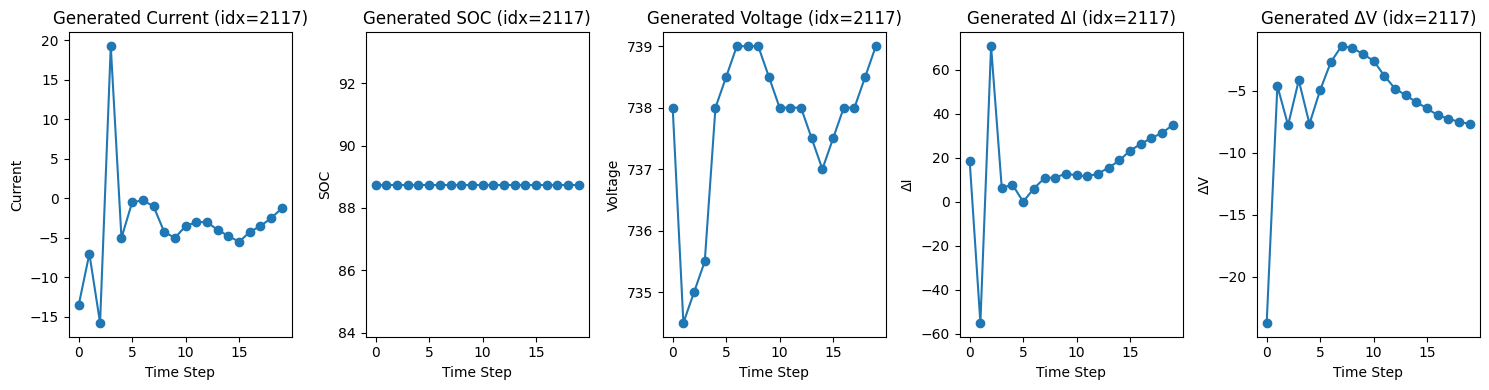

Sample idx 3349 | Latent dynamic shape: (1, 20, 4)
Sample idx 3349 | Generated sequence shape: (1, 20, 5)


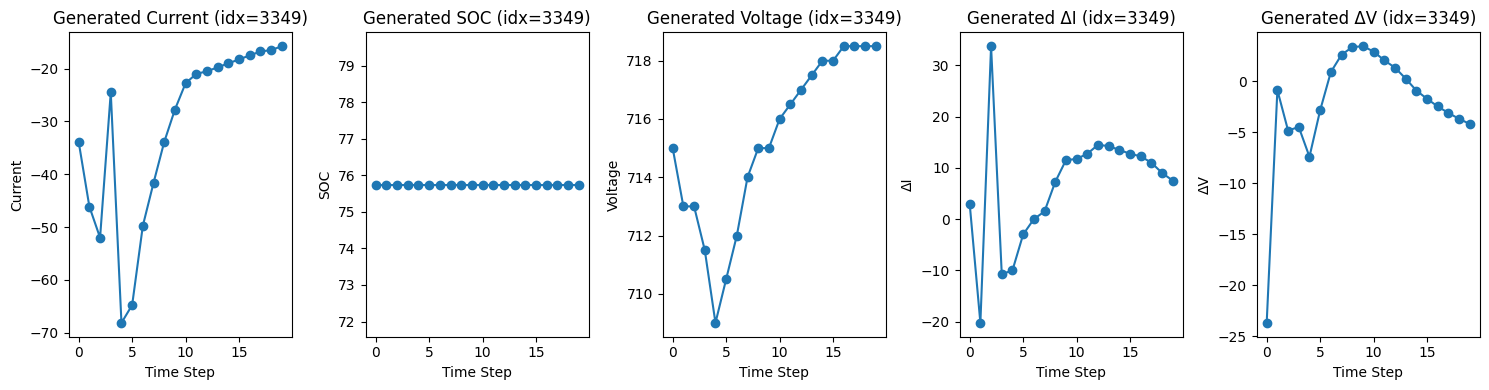

Sample idx 2486 | Latent dynamic shape: (1, 20, 4)
Sample idx 2486 | Generated sequence shape: (1, 20, 5)


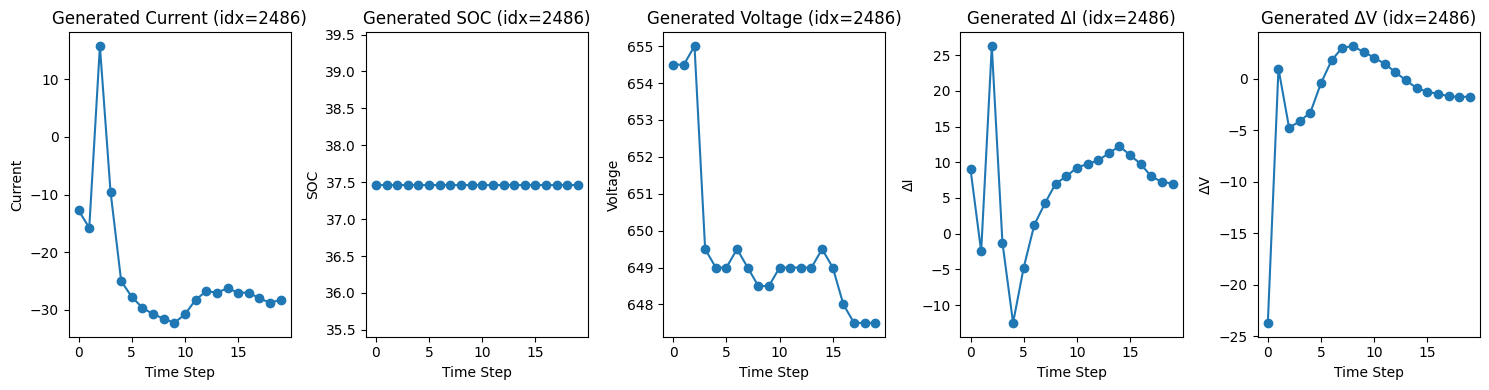

Sample idx 146 | Latent dynamic shape: (1, 20, 4)
Sample idx 146 | Generated sequence shape: (1, 20, 5)


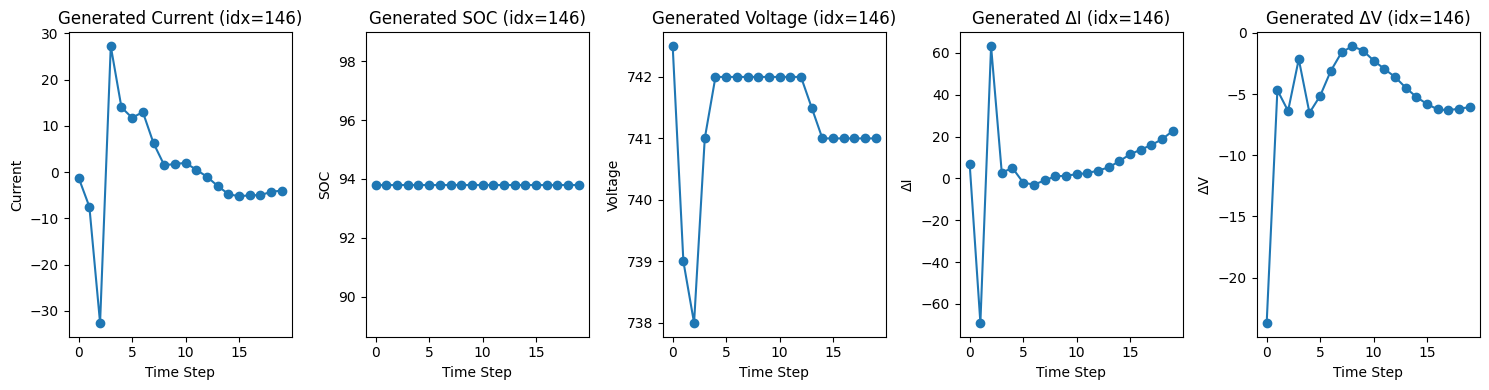

Sample idx 138 | Latent dynamic shape: (1, 20, 4)
Sample idx 138 | Generated sequence shape: (1, 20, 5)


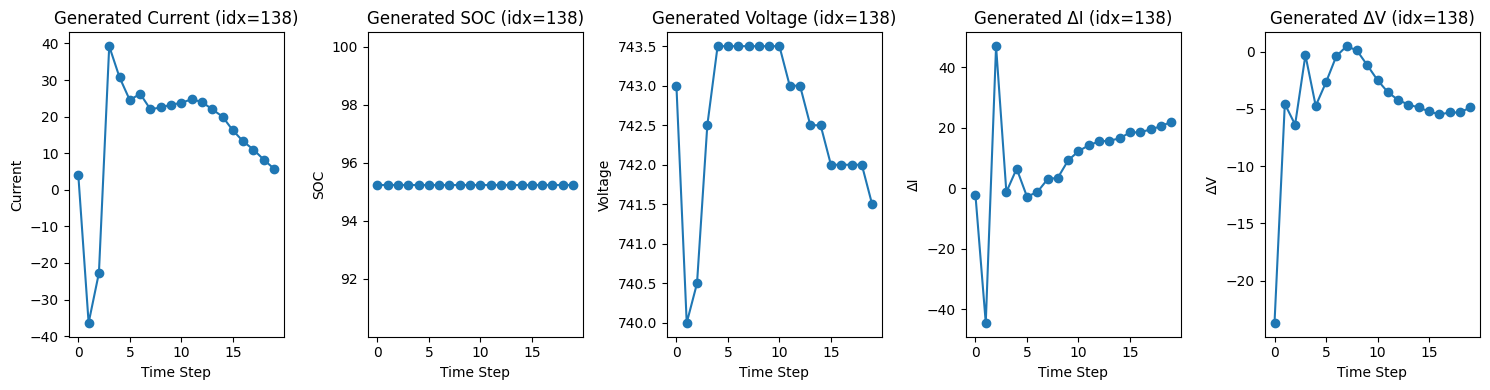

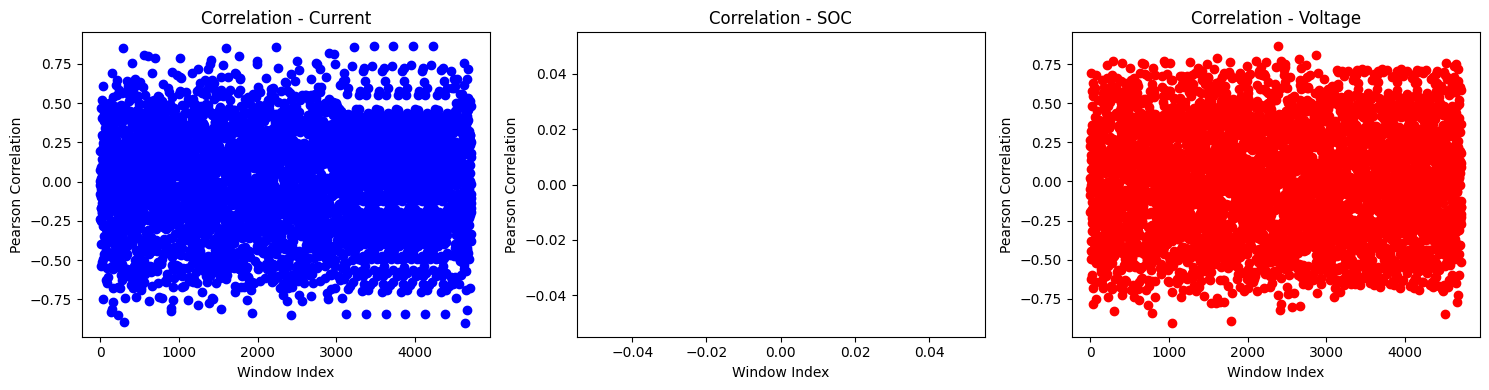

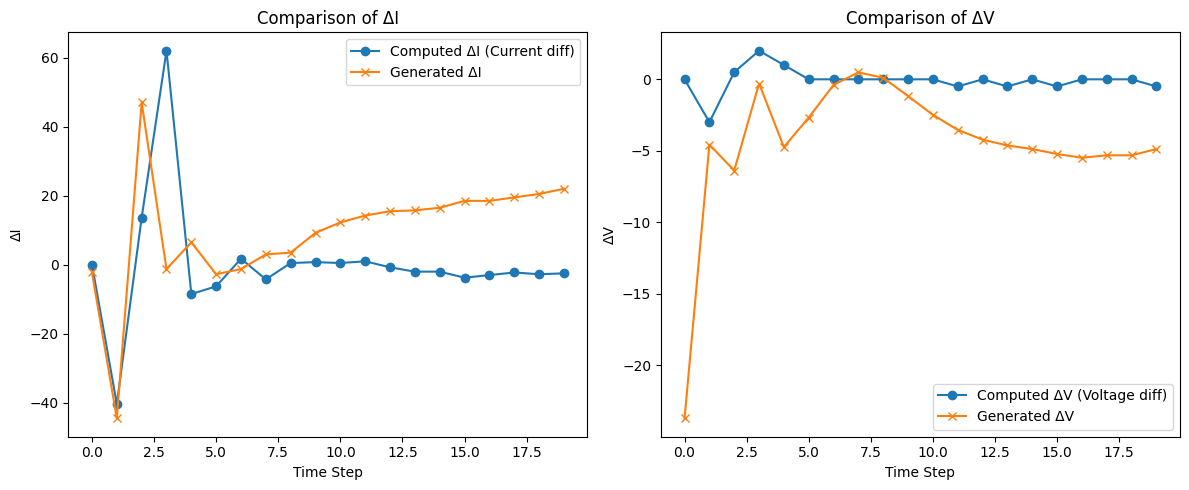

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 5개의 랜덤 샘플 인덱스 선택 (all_sequences의 shape: (num_sequences, window_size, 5))
random_indices = np.random.choice(len(all_sequences), size=5, replace=False)

for idx in random_indices:
    # 해당 샘플의 시퀀스 추출 (shape: (1, window_size, 5))
    sample_seq = all_sequences[idx:idx+1]

    # 조건(SOC) 추출: sample_seq로부터 get_condition 호출 (shape: (1, window_size, 1))
    cond_sample = get_condition(sample_seq)

    # 임의의 노이즈 샘플 생성 (shape: (1, window_size, latent_dim))
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # 조건부 Generator 실행: Generator는 4채널 출력 (ordering: [Current, ΔI, ΔV, Voltage])
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
    print(f"Sample idx {idx} | Latent dynamic shape: {latent_dynamic.shape}")  # 예상: (1, window_size, 4)

    # combine_output: Generator 출력에 조건(SOC)을 삽입하여 최종 생성 시퀀스 구성
    # 최종 ordering: [Current, SOC, Voltage, ΔI, ΔV]
    generated_sequence = combine_output(latent_dynamic, cond_sample)
    print(f"Sample idx {idx} | Generated sequence shape: {generated_sequence.shape}")  # 예상: (1, window_size, 5)

    # 첫 번째 시퀀스 추출 (shape: (window_size, 5))
    gen_seq = generated_sequence[0].numpy()

    # 각 피처별 denormalization
    # 인덱스: 0: Current, 1: SOC, 2: Voltage, 3: ΔI, 4: ΔV
    gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
    gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
    gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
    gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)
    gen_deltaV_denorm  = denormalize_feature(gen_seq, 4, data_min, data_max)

    # 각 피처별 생성 데이터 시각화
    plt.figure(figsize=(15,4))

    plt.subplot(1,5,1)
    plt.plot(gen_current_denorm, marker='o')
    plt.title(f'Generated Current (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Current')

    plt.subplot(1,5,2)
    plt.plot(gen_soc_denorm, marker='o')
    plt.title(f'Generated SOC (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('SOC')

    plt.subplot(1,5,3)
    plt.plot(gen_voltage_denorm, marker='o')
    plt.title(f'Generated Voltage (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')

    plt.subplot(1,5,4)
    plt.plot(gen_deltaI_denorm, marker='o')
    plt.title(f'Generated ΔI (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')

    plt.subplot(1,5,5)
    plt.plot(gen_deltaV_denorm, marker='o')
    plt.title(f'Generated ΔV (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔV')

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 슬라이딩 윈도우별 상관계수 계산 (원본 all_sequences는 (N, window_size, 5), 순서: [Current, SOC, Voltage, ΔI, ΔV])
# 여기서는 [Current, SOC, Voltage] (인덱스 0, 1, 2)에 대해 Pearson 상관계수를 계산합니다.
n_windows = all_sequences.shape[0]
corr_current = []
corr_soc = []
corr_voltage = []

# 우선, denormalize된 생성된 시퀀스의 각 피처 (위의 gen_*_denorm)와 비교할 대상은 랜덤 샘플이 아닌,
# 전체 all_sequences에서 각 윈도우에 대해 [Current, SOC, Voltage] 피처를 추출하여 denormalize한 값입니다.
for i in range(n_windows):
    window = all_sequences[i]  # (window_size, 5)
    window_current = denormalize_feature(window, 0, data_min, data_max)
    window_soc     = denormalize_feature(window, 1, data_min, data_max)
    window_voltage = denormalize_feature(window, 2, data_min, data_max)

    # 계산: gen_current_denorm, gen_soc_denorm, gen_voltage_denorm은 위에서 랜덤 샘플에서 얻은 값
    # 여기서는 각 윈도우와 그 랜덤 샘플 간의 상관계수를 계산
    corr_current.append(np.corrcoef(window_current.ravel(), gen_current_denorm.ravel())[0, 1])
    corr_soc.append(np.corrcoef(window_soc.ravel(), gen_soc_denorm.ravel())[0, 1])
    corr_voltage.append(np.corrcoef(window_voltage.ravel(), gen_voltage_denorm.ravel())[0, 1])

# 상관계수 결과 플롯 (피처별)
x = np.arange(n_windows)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.scatter(x, corr_current, marker='o', color='blue')
plt.title('Correlation - Current')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,2)
plt.scatter(x, corr_soc, marker='o', color='green')
plt.title('Correlation - SOC')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.subplot(1,3,3)
plt.scatter(x, corr_voltage, marker='o', color='red')
plt.title('Correlation - Voltage')
plt.xlabel('Window Index')
plt.ylabel('Pearson Correlation')

plt.tight_layout()
plt.show()

computed_deltaI = np.diff(gen_current_denorm, prepend=gen_current_denorm[0])
computed_deltaV = np.diff(gen_voltage_denorm, prepend=gen_voltage_denorm[0])

# 플롯: 왼쪽은 ΔI 비교, 오른쪽은 ΔV 비교
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(computed_deltaI, label='Computed ΔI (Current diff)', marker='o')
plt.plot(gen_deltaI_denorm, label='Generated ΔI', marker='x')
plt.title('Comparison of ΔI')
plt.xlabel('Time Step')
plt.ylabel('ΔI')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(computed_deltaV, label='Computed ΔV (Voltage diff)', marker='o')
plt.plot(gen_deltaV_denorm, label='Generated ΔV', marker='x')
plt.title('Comparison of ΔV')
plt.xlabel('Time Step')
plt.ylabel('ΔV')
plt.legend()

plt.tight_layout()
plt.show()


Sample idx 1032 | Latent dynamic shape: (1, 20, 4)
Sample idx 1032 | Generated sequence shape: (1, 20, 5)


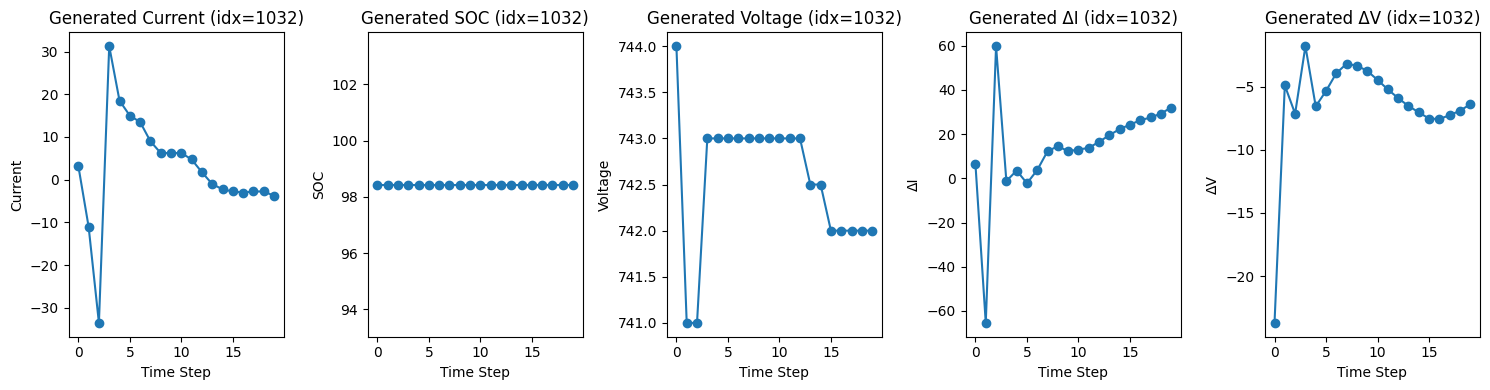

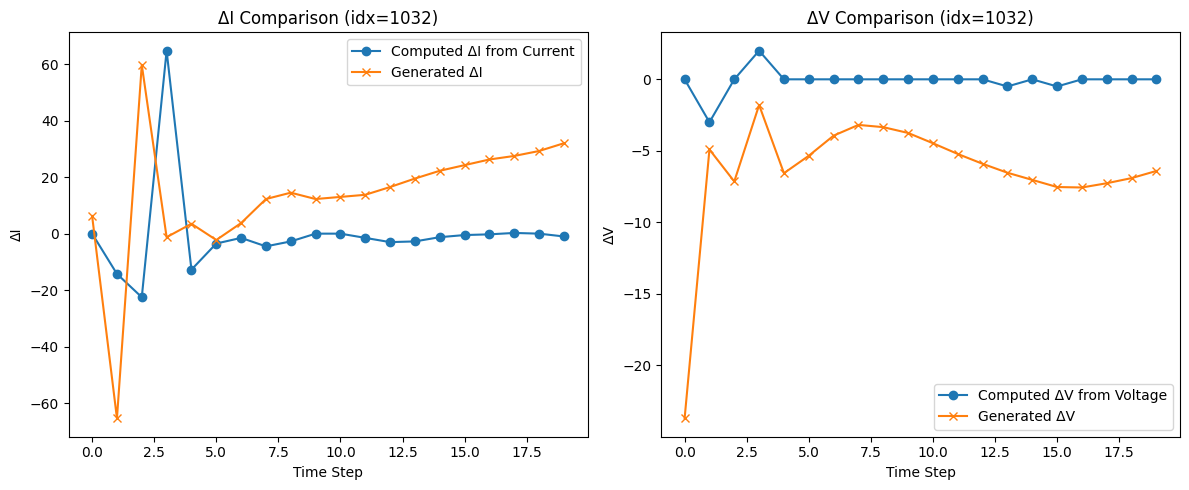

Sample idx 2675 | Latent dynamic shape: (1, 20, 4)
Sample idx 2675 | Generated sequence shape: (1, 20, 5)


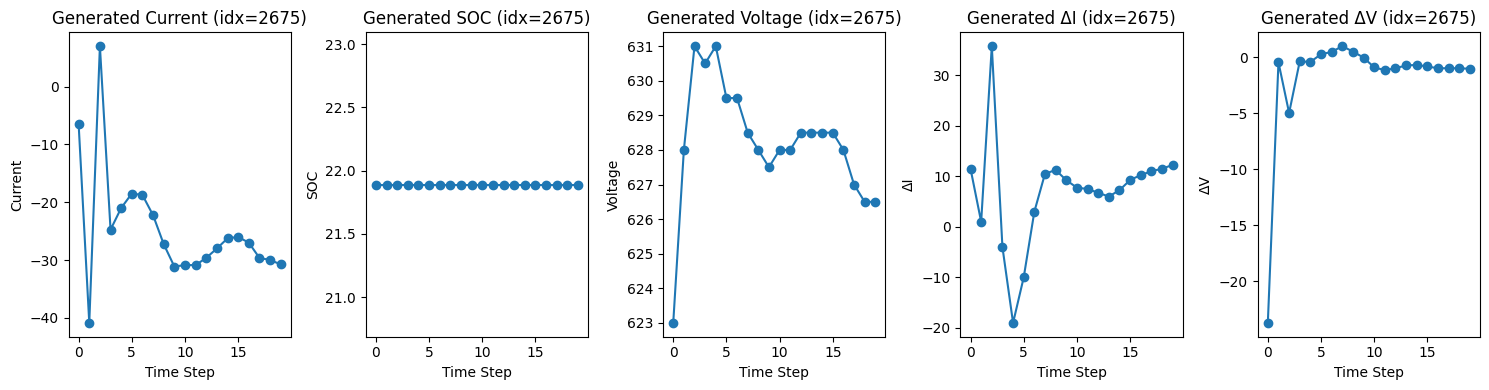

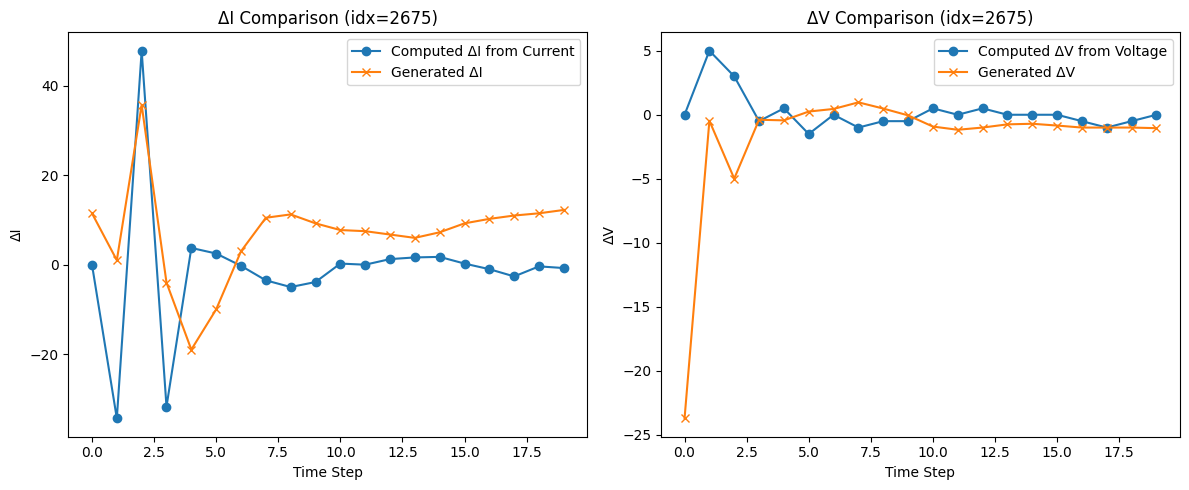

Sample idx 4527 | Latent dynamic shape: (1, 20, 4)
Sample idx 4527 | Generated sequence shape: (1, 20, 5)


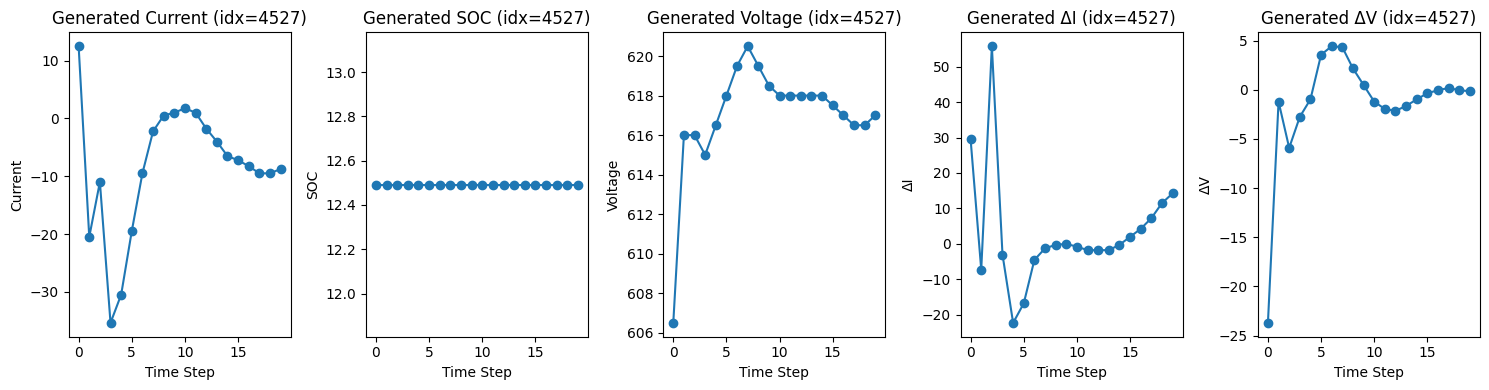

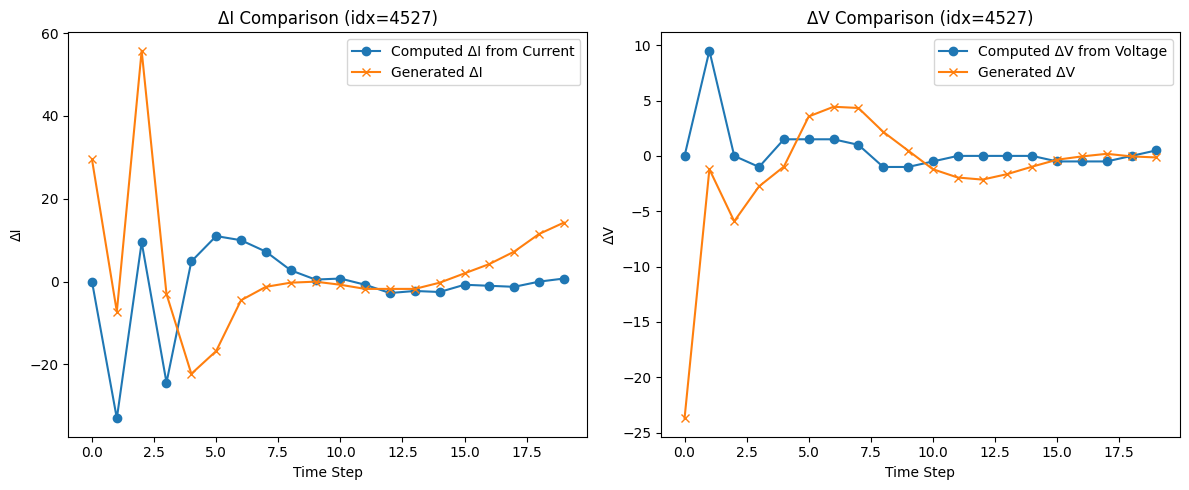

Sample idx 1459 | Latent dynamic shape: (1, 20, 4)
Sample idx 1459 | Generated sequence shape: (1, 20, 5)


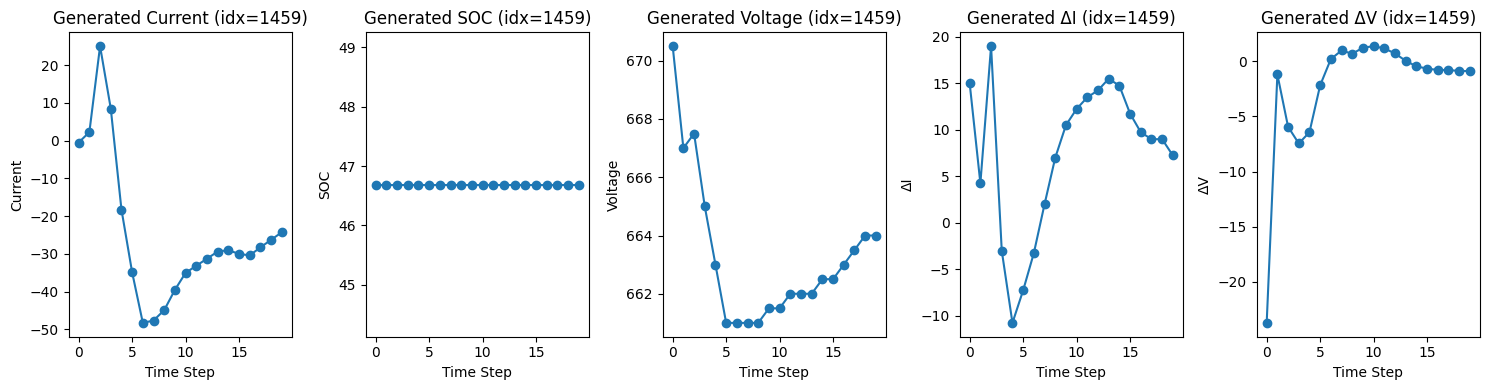

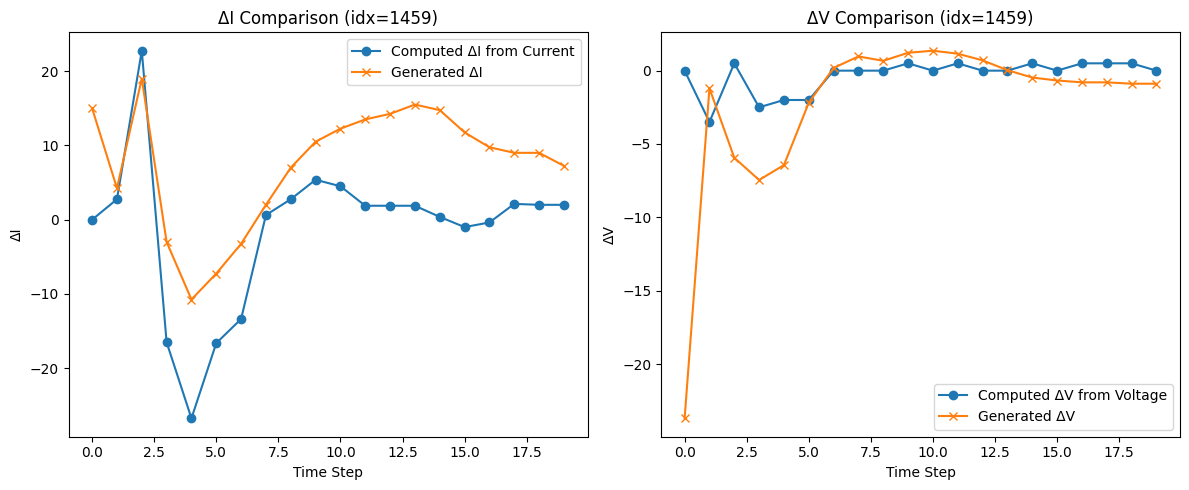

Sample idx 1214 | Latent dynamic shape: (1, 20, 4)
Sample idx 1214 | Generated sequence shape: (1, 20, 5)


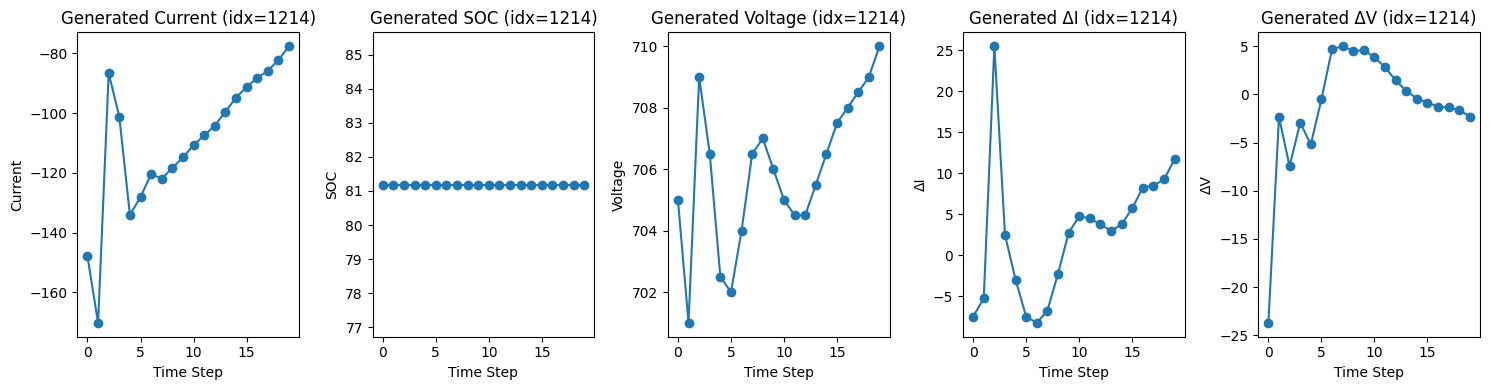

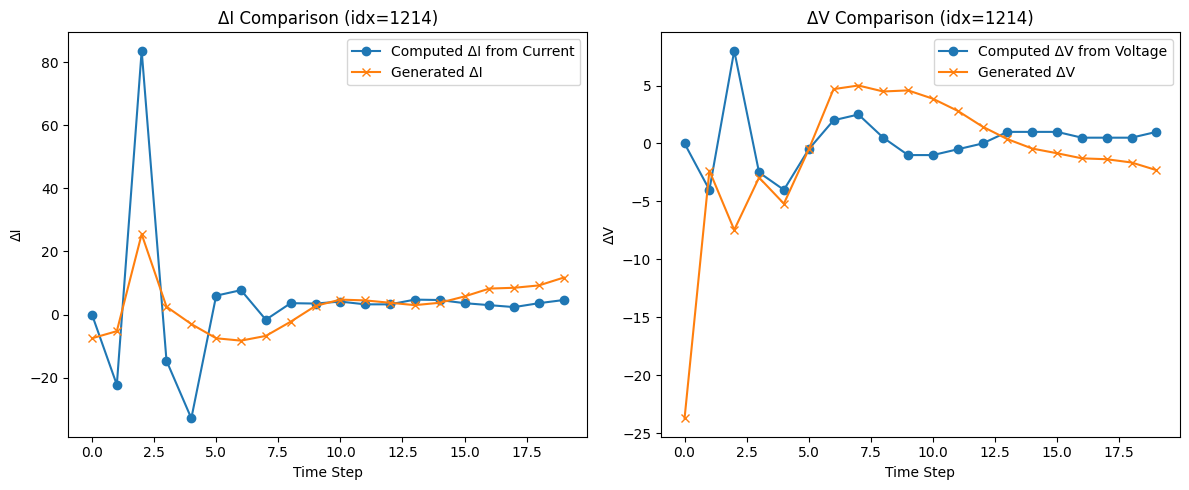

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# --- 최종 combine_output 함수 ---
# Generator의 원래 출력은 4채널: [Current, ΔI, ΔV, Voltage]
# 이를 재배열하여 최종 생성 시퀀스 ordering을 [Current, SOC, Voltage, ΔI, ΔV]로 만듭니다.
def combine_output(dynamic, cond):
    # dynamic: (batch, window_size, 4) → [Current, ΔI, ΔV, Voltage]
    current = dynamic[..., :1]          # [Current]
    remaining = dynamic[..., 1:]          # [ΔI, ΔV, Voltage] (원래 순서)
    # 재배열: Voltage를 맨 앞에 오게 하고, ΔI, ΔV는 뒤로 보냄
    voltage = remaining[..., -1:]
    delta = remaining[..., :2]
    cond = tf.cast(cond, dynamic.dtype)   # [SOC]
    # 최종 ordering: [Current, SOC, Voltage, ΔI, ΔV]
    return tf.concat([current, cond, voltage, delta], axis=-1)

# -------------------------------------------------------------------
# 5개의 랜덤 샘플에 대해 생성 결과 및 비교 플롯
# -------------------------------------------------------------------
num_plots = 5
random_indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

for idx in random_indices:
    # 해당 샘플 시퀀스 (shape: (1, window_size, 5))에서 조건 추출
    sample_seq = all_sequences[idx:idx+1]
    cond_sample = get_condition(sample_seq)  # (1, window_size, 1)

    # 임의의 노이즈 생성 (shape: (1, window_size, latent_dim))
    noise_sample = tf.random.normal([1, window_size, latent_dim])

    # 조건부 Generator 실행: Generator는 4채널 출력, ordering: [Current, ΔI, ΔV, Voltage]
    latent_dynamic = generator_cond([noise_sample, cond_sample], training=False)
    print(f"Sample idx {idx} | Latent dynamic shape: {latent_dynamic.shape}")  # 예상: (1, window_size, 4)

    # combine_output: 최종 생성 시퀀스 구성, ordering: [Current, SOC, Voltage, ΔI, ΔV]
    generated_sequence = combine_output(latent_dynamic, cond_sample)
    print(f"Sample idx {idx} | Generated sequence shape: {generated_sequence.shape}")  # 예상: (1, window_size, 5)

    # 첫 번째 시퀀스 추출 (shape: (window_size, 5))
    gen_seq = generated_sequence[0].numpy()

    # 각 피처별 denormalization (data_min, data_max는 원래 [Current, SOC, Voltage, ΔI, ΔV] 순서)
    gen_current_denorm = denormalize_feature(gen_seq, 0, data_min, data_max)
    gen_soc_denorm     = denormalize_feature(gen_seq, 1, data_min, data_max)
    gen_voltage_denorm = denormalize_feature(gen_seq, 2, data_min, data_max)
    gen_deltaI_denorm  = denormalize_feature(gen_seq, 3, data_min, data_max)
    gen_deltaV_denorm  = denormalize_feature(gen_seq, 4, data_min, data_max)

    # 생성된 Current, SOC, Voltage, ΔI, ΔV 플롯
    plt.figure(figsize=(15,4))
    plt.subplot(1,5,1)
    plt.plot(gen_current_denorm, marker='o')
    plt.title(f'Generated Current (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Current')

    plt.subplot(1,5,2)
    plt.plot(gen_soc_denorm, marker='o')
    plt.title(f'Generated SOC (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('SOC')

    plt.subplot(1,5,3)
    plt.plot(gen_voltage_denorm, marker='o')
    plt.title(f'Generated Voltage (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('Voltage')

    plt.subplot(1,5,4)
    plt.plot(gen_deltaI_denorm, marker='o')
    plt.title(f'Generated ΔI (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')

    plt.subplot(1,5,5)
    plt.plot(gen_deltaV_denorm, marker='o')
    plt.title(f'Generated ΔV (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔV')

    plt.tight_layout()
    plt.show()

    # 추가: Generated Current와 Voltage의 시간차분을 계산하여 Δ 비교
    computed_deltaI = np.diff(gen_current_denorm, prepend=gen_current_denorm[0])
    computed_deltaV = np.diff(gen_voltage_denorm, prepend=gen_voltage_denorm[0])

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(computed_deltaI, marker='o', label='Computed ΔI from Current')
    plt.plot(gen_deltaI_denorm, marker='x', label='Generated ΔI')
    plt.title(f'ΔI Comparison (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔI')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(computed_deltaV, marker='o', label='Computed ΔV from Voltage')
    plt.plot(gen_deltaV_denorm, marker='x', label='Generated ΔV')
    plt.title(f'ΔV Comparison (idx={idx})')
    plt.xlabel('Time Step')
    plt.ylabel('ΔV')
    plt.legend()

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 1s 792ms/step
[Window index: 3272]
  1D-CNN -> MSE: 18.8835, Pearson Corr: 0.8697
  LSTM   -> MSE: 25.8360, Pearson Corr: 0.7086


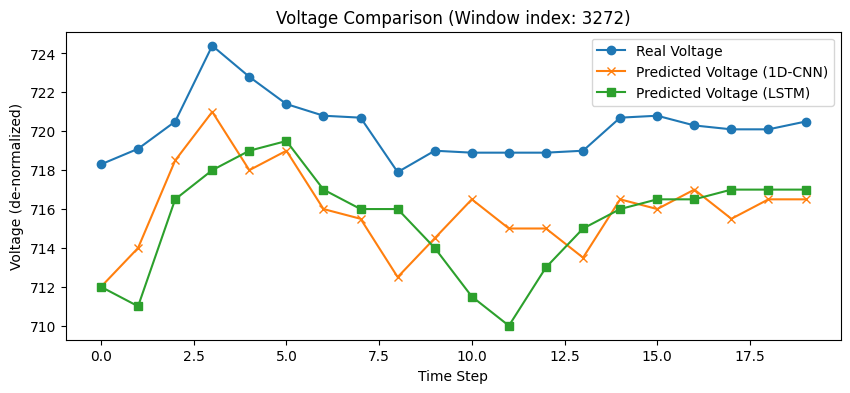

1/1 [==============================] - 0s 16ms/step
[Window index: 4112]
  1D-CNN -> MSE: 10.5625, Pearson Corr: 0.7803
  LSTM   -> MSE: 28.6500, Pearson Corr: 0.8476


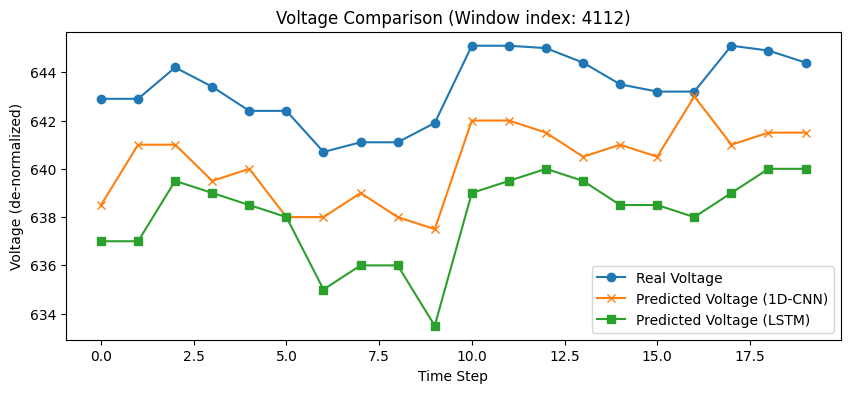

1/1 [==============================] - 0s 17ms/step
[Window index: 2103]
  1D-CNN -> MSE: 3.3825, Pearson Corr: 0.9424
  LSTM   -> MSE: 11.9025, Pearson Corr: 0.4298


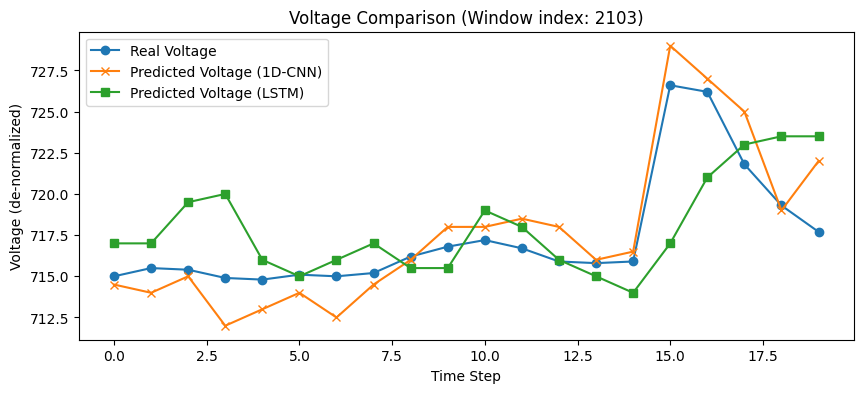

1/1 [==============================] - 0s 16ms/step
[Window index: 1464]
  1D-CNN -> MSE: 2.5260, Pearson Corr: 0.1701
  LSTM   -> MSE: 10.6085, Pearson Corr: 0.4779


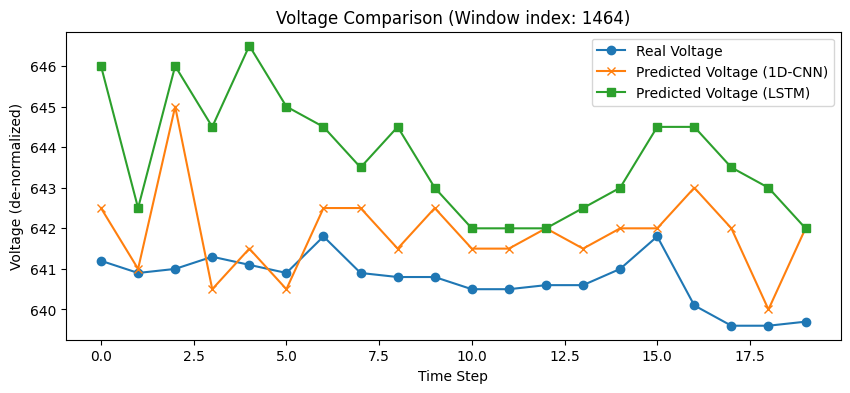

1/1 [==============================] - 0s 17ms/step
[Window index: 2170]
  1D-CNN -> MSE: 4.7875, Pearson Corr: 0.9368
  LSTM   -> MSE: 2.6725, Pearson Corr: 0.6452


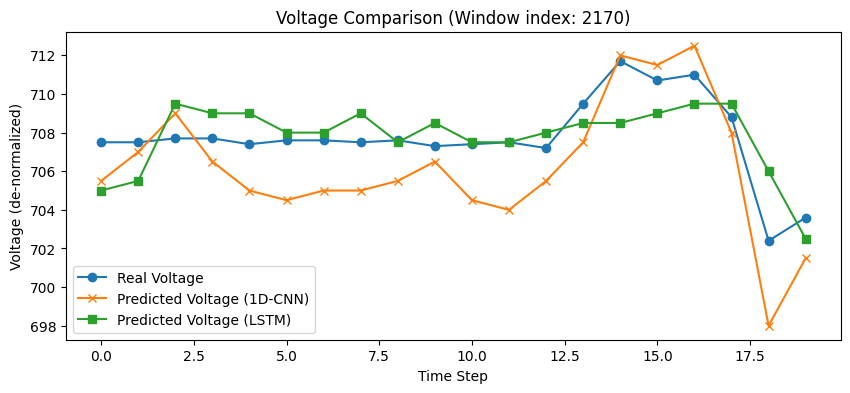

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

num_plots = 5
indices = np.random.choice(len(all_sequences), size=num_plots, replace=False)

voltage_model = teacher_model
voltage_model_2 = teacher_model_2

for idx in indices:
    # (1) 해당 윈도우에서 Teacher 모델 입력과 정답 전압 추출
    # all_sequences의 열 순서: [전류, SOC, 전압, △I, △V]
    # Teacher 모델 입력: [전류, SOC, △I, △V] → 원래는 (window_size, 4)
    teacher_input_data = all_sequences[idx, :, [0, 1, 3, 4]]
    # 만약 teacher_input_data의 shape가 (4, window_size)로 나온다면, transpose합니다.
    if teacher_input_data.shape[0] == 4:
        teacher_input_data = np.transpose(teacher_input_data, (1, 0))  # (window_size, 4)

    # 정답 전압: 열 인덱스 2
    real_voltage = all_sequences[idx, :, 2]  # (window_size,)

    # (2) Teacher 모델 입력 준비: (1, window_size, 4)
    teacher_input = np.expand_dims(teacher_input_data, axis=0)

    # (3) Teacher 모델 예측
    # Teacher 모델 1 (1D-CNN 기반)
    predicted_voltage_cnn = voltage_model.predict(teacher_input)  # (1, window_size, 1)
    predicted_voltage_cnn = predicted_voltage_cnn[0, :, 0]  # (window_size,)

    # Teacher 모델 2 (LSTM 기반)
    predicted_voltage_lstm = voltage_model_2.predict(teacher_input)  # (1, window_size, 1)
    predicted_voltage_lstm = predicted_voltage_lstm[0, :, 0]  # (window_size,)

    # (4) De-normalize: 전압은 feature index 2의 스케일 사용 (data_min, data_max는 [전류, SOC, 전압, △I, △V])
    real_voltage_denorm = denorm_vector(real_voltage, 2, data_min, data_max)
    predicted_voltage_cnn_denorm = denorm_vector(predicted_voltage_cnn, 2, data_min, data_max)
    predicted_voltage_lstm_denorm = denorm_vector(predicted_voltage_lstm, 2, data_min, data_max)

    # (5) 평가: MSE 및 Pearson 상관계수 계산
    mse_cnn = np.mean((real_voltage_denorm - predicted_voltage_cnn_denorm) ** 2)
    corr_cnn = np.corrcoef(real_voltage_denorm, predicted_voltage_cnn_denorm)[0, 1]

    mse_lstm = np.mean((real_voltage_denorm - predicted_voltage_lstm_denorm) ** 2)
    corr_lstm = np.corrcoef(real_voltage_denorm, predicted_voltage_lstm_denorm)[0, 1]

    print(f"[Window index: {idx}]")
    print(f"  1D-CNN -> MSE: {mse_cnn:.4f}, Pearson Corr: {corr_cnn:.4f}")
    print(f"  LSTM   -> MSE: {mse_lstm:.4f}, Pearson Corr: {corr_lstm:.4f}")

    # (6) 시각화: 실제 전압과 두 Teacher 모델 예측 전압 비교
    plt.figure(figsize=(10,4))
    plt.plot(real_voltage_denorm, label="Real Voltage", marker='o')
    plt.plot(predicted_voltage_cnn_denorm, label="Predicted Voltage (1D-CNN)", marker='x')
    plt.plot(predicted_voltage_lstm_denorm, label="Predicted Voltage (LSTM)", marker='s')
    plt.title(f"Voltage Comparison (Window index: {idx})")
    plt.xlabel("Time Step")
    plt.ylabel("Voltage (de-normalized)")
    plt.legend()
    plt.show()
